**https://ods.ai/competitions/mtsmlcup**


LB = 1,5856361298









# Загрузка библиотек

In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import hstack
from scipy import sparse
import bisect
import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# Загрузка данных

In [5]:
# id для сабмита
id_to_submit = pd.read_feather('/kaggle/input/mts-ml-cookies/submission.feather')
id_to_submit.head(2)

,user_id
0,221301
1,31271


In [6]:
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144724 entries, 0 to 144723
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  144724 non-null  int32
dtypes: int32(1)
memory usage: 565.5 KB


In [7]:
# целевые признаки для обучения
target_train = pd.read_feather('/kaggle/input/mts-ml-cookies/target_train.feather')
target_train.user_id = target_train.user_id.astype('int32')
target_train.head(2)

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276


In [8]:
# оставим только пользователей младше 70 лет 
target_train = target_train[target_train.age<70]
target_train.head(2)

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276


In [9]:
target_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268252 entries, 0 to 269999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   age      268252 non-null  float64
 1   is_male  262618 non-null  object 
 2   user_id  268252 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 7.2+ MB


In [10]:
# загрузка основного датасета
data = pd.read_csv('/kaggle/input/url-hosts-join/data_clear.csv')
data

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join
0,0,s0.2mdn.net avatars.mds.yandex.net googleads.g...,52,Москва,Samsung Galaxy J1 2016 LTE Dual,56,54,20,1,4,43,36,5,9,23,11,17,1,Москва
1,1,avatars.mds.yandex.net i.ytimg.com ads.between...,136,Москва,Xiaomi Mi 9,227,202,237,34,118,99,151,90,93,77,72,19,3,Московскаяобласть Москва Санкт-Петербург
2,2,lentaru.media.eagleplatform.com i.ytimg.com no...,51,Республика Коми,Huawei Honor 9 Lite,172,106,72,6,44,48,66,42,55,46,55,50,1,РеспубликаКоми
3,3,ad.mail.ru avatars.mds.yandex.net mail.yandex....,43,Воронежская область,Huawei Device Company Limited P Smart 2021,67,75,44,2,28,17,28,26,48,14,27,15,1,Воронежскаяобласть
4,4,kp.md yastatic.net avatars.mds.yandex.net sun9...,108,Краснодарский край,Huawei Nova 3,199,170,212,10,92,38,62,73,112,114,100,20,5,Краснодарскийкрай РеспубликаБашкортостан Самар...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414956,415312,googleads.g.doubleclick.net,1,Тамбовская область,Huawei Honor 7S Dual,1,0,0,0,0,0,0,1,0,0,0,1,1,Тамбовскаяобласть
414957,415313,avatars.mds.yandex.net,1,Саратовская область,Xiaomi Redmi 6A,1,0,0,0,0,0,0,0,0,1,0,1,1,Саратовскаяобласть
414958,415314,vk.com,1,Новосибирская область,Huawei Device Company Limited Honor 10X Lite,1,0,0,0,1,0,0,0,0,0,0,1,1,Новосибирскаяобласть
414959,415315,yandex.ru,1,Краснодарский край,Huawei Honor 7S Dual,1,0,0,0,0,0,0,0,0,0,1,1,1,Краснодарскийкрай


## Датасет для обучения

In [11]:
# объединим урлы с таргет-трейн
data_target = target_train.merge(data, on="user_id", how="left")
data_target.head(2)

,age,is_male,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,...,0,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join
0,31.0,1,350459,sun9-29.userapi.com id.tinkoff.ru vk.com onlin...,36.0,Удмуртская Республика,Xiaomi Redmi Note 7,84.0,27.0,67.0,...,19.0,28.0,33.0,44.0,29.0,18.0,7.0,28.0,1.0,УдмуртскаяРеспублика
1,35.0,1,188276,onlayn-radio.ru online.sberbank.ru googleads.g...,21.0,Ленинградская область,Samsung Galaxy A8 2018 Dual,33.0,41.0,27.0,...,26.0,5.0,10.0,19.0,22.0,14.0,15.0,14.0,1.0,Ленинградскаяобласть


In [12]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268252 entries, 0 to 268251
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               268252 non-null  float64
 1   is_male           262618 non-null  object 
 2   user_id           268252 non-null  int32  
 3   url_host          267897 non-null  object 
 4   uniq_urls_cnt     267897 non-null  float64
 5   region_name       267897 non-null  object 
 6   cpe               267897 non-null  object 
 7   day               267897 non-null  float64
 8   evening           267897 non-null  float64
 9   morning           267897 non-null  float64
 10  night             267897 non-null  float64
 11  0                 267897 non-null  float64
 12  1                 267897 non-null  float64
 13  2                 267897 non-null  float64
 14  3                 267897 non-null  float64
 15  4                 267897 non-null  float64
 16  5                 26

## Датасет для сабмита

In [13]:
submit = id_to_submit.merge(data, on="user_id", how="left")
submit.head(2)

,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join
0,221301,googleads.g.doubleclick.net sun9-29.userapi.co...,46,Республика Башкортостан,Apple iPhone SE,192,161,120,91,53,77,90,85,81,62,116,19,1,РеспубликаБашкортостан
1,31271,yandex.ru yastatic.net zen.yandex.ru avatars.m...,4,Липецкая область,Samsung Galaxy A30 Dual,4,0,0,0,4,0,0,0,0,0,0,1,1,Липецкаяобласть


In [14]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144724 entries, 0 to 144723
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           144724 non-null  int32 
 1   url_host          144724 non-null  object
 2   uniq_urls_cnt     144724 non-null  int64 
 3   region_name       144724 non-null  object
 4   cpe               144724 non-null  object
 5   day               144724 non-null  int64 
 6   evening           144724 non-null  int64 
 7   morning           144724 non-null  int64 
 8   night             144724 non-null  int64 
 9   0                 144724 non-null  int64 
 10  1                 144724 non-null  int64 
 11  2                 144724 non-null  int64 
 12  3                 144724 non-null  int64 
 13  4                 144724 non-null  int64 
 14  5                 144724 non-null  int64 
 15  6                 144724 non-null  int64 
 16  days_cnt          144724 non-null  int

# Обучение


## Пол: обучение

In [15]:
# возьмем только нужные признаки и сразу удалим пропуски
data_sex = data_target.drop(columns=('age')).dropna()
data_sex.head(2)

,is_male,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join
0,1,350459,sun9-29.userapi.com id.tinkoff.ru vk.com onlin...,36.0,Удмуртская Республика,Xiaomi Redmi Note 7,84.0,27.0,67.0,0.0,19.0,28.0,33.0,44.0,29.0,18.0,7.0,28.0,1.0,УдмуртскаяРеспублика
1,1,188276,onlayn-radio.ru online.sberbank.ru googleads.g...,21.0,Ленинградская область,Samsung Galaxy A8 2018 Dual,33.0,41.0,27.0,10.0,26.0,5.0,10.0,19.0,22.0,14.0,15.0,14.0,1.0,Ленинградскаяобласть


In [16]:
data_sex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262265 entries, 0 to 268251
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   is_male           262265 non-null  object 
 1   user_id           262265 non-null  int32  
 2   url_host          262265 non-null  object 
 3   uniq_urls_cnt     262265 non-null  float64
 4   region_name       262265 non-null  object 
 5   cpe               262265 non-null  object 
 6   day               262265 non-null  float64
 7   evening           262265 non-null  float64
 8   morning           262265 non-null  float64
 9   night             262265 non-null  float64
 10  0                 262265 non-null  float64
 11  1                 262265 non-null  float64
 12  2                 262265 non-null  float64
 13  3                 262265 non-null  float64
 14  4                 262265 non-null  float64
 15  5                 262265 non-null  float64
 16  6                 26

In [17]:
# урлы-предикторы преобразуем в векторы
tfidf_urls_sex = TfidfVectorizer()
X_urls_sex = tfidf_urls_sex.fit_transform(data_sex['url_host'])
X_urls_sex

<262265x96001 sparse matrix of type '<class 'numpy.float64'>'
	with 26870913 stored elements in Compressed Sparse Row format>

In [18]:
# кодирование моделей телефона
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_cpe_sex = ohe.fit(np.array(data_sex.cpe).reshape(-1, 1))
X_cpe_sex = ohe_cpe_sex.transform(np.array(data_sex.cpe).reshape(-1, 1))
X_cpe_sex

<262265x603 sparse matrix of type '<class 'numpy.float64'>'
	with 262265 stored elements in Compressed Sparse Row format>

In [19]:
# матрица данных по частям суток
X_part_of_day_cnt_sex = sparse.csr_matrix(np.array(data_sex[['day', 'evening', 'morning', 'night']]))
X_part_of_day_cnt_sex

<262265x4 sparse matrix of type '<class 'numpy.float64'>'
	with 964317 stored elements in Compressed Sparse Row format>

In [20]:
# кодирование регионов
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_region_sex = ohe.fit(np.array(data_sex.region_name).reshape(-1, 1))
X_region_sex = ohe_region_sex.transform(np.array(data_sex.region_name).reshape(-1, 1))
X_region_sex

<262265x283 sparse matrix of type '<class 'numpy.float64'>'
	with 262265 stored elements in Compressed Sparse Row format>

In [21]:
# матрица кол-ва уникальных урлов
X_uniq_urls_cnt_sex = sparse.csr_matrix(np.array(data_sex['uniq_urls_cnt']).reshape(-1, 1))
X_uniq_urls_cnt_sex

<262265x1 sparse matrix of type '<class 'numpy.float64'>'
	with 262265 stored elements in Compressed Sparse Row format>

In [22]:
# матрица данных по дням недели
X_weekday_sex = sparse.csr_matrix(np.array(data_sex[['0', '1', '2', '3', '4', '5', '6']]))
X_weekday_sex

<262265x7 sparse matrix of type '<class 'numpy.float64'>'
	with 1569445 stored elements in Compressed Sparse Row format>

In [23]:
# матрица кол-ва дней
X_days_cnt_sex = sparse.csr_matrix(np.array(data_sex['days_cnt']).reshape(-1, 1))
X_days_cnt_sex

<262265x1 sparse matrix of type '<class 'numpy.float64'>'
	with 262265 stored elements in Compressed Sparse Row format>

In [24]:
# матрица кол-ва регионов
X_regions_cnt_sex = sparse.csr_matrix(np.array(data_sex['regions_cnt']).reshape(-1, 1))
X_regions_cnt_sex

<262265x1 sparse matrix of type '<class 'numpy.float64'>'
	with 262265 stored elements in Compressed Sparse Row format>

In [25]:
# список регионов преобразуем в векторы
tfidf_regions_sex = TfidfVectorizer()
X_regions_join_sex = tfidf_regions_sex.fit_transform(data_sex['region_name_join'])
X_regions_join_sex

<262265x89 sparse matrix of type '<class 'numpy.float64'>'
	with 514421 stored elements in Compressed Sparse Row format>

In [26]:
# фичи для предсказания пола
X_sex = hstack((X_urls_sex, X_cpe_sex, X_part_of_day_cnt_sex, X_region_sex, X_uniq_urls_cnt_sex, \
                X_weekday_sex, X_days_cnt_sex, X_regions_cnt_sex, X_regions_join_sex))
X_sex

<262265x96990 sparse matrix of type '<class 'numpy.float64'>'
	with 31230421 stored elements in COOrdinate format>

In [27]:
y_sex = data_sex['is_male']

In [28]:
pipe_sex = make_pipeline(MaxAbsScaler(), LogisticRegression(solver='saga', max_iter=300, random_state=10, n_jobs=-1))
cls_sex = BaggingClassifier(pipe_sex, n_estimators=10, random_state=10, verbose=1, n_jobs=-1)

In [29]:
# кросс-валидация
#cross_val = cross_validate(bagging_sex, X_sex, y_sex, cv=3, return_train_score=True)
#print('train score: ', cross_val['train_score'])
#print('test score: ', cross_val['test_score'])

In [30]:
#X_sex =X_urls_sex
#train score:  [0.83104922 0.83111732 0.83129419]
#test score:  [0.77325812 0.77027318 0.77209788]

#X_urls_sex, X_cpe_sex, X_part_of_day_cnt_sex
#train score:  [0.83532236 0.83496484 0.83460259]
#test score:  [0.77505136 0.77173728 0.77460617]

#X_sex = hstack((X_urls_sex, X_cpe_sex, X_part_of_day_cnt_sex, X_region_sex, X_uniq_urls_cnt_sex))
#train score:  [0.83576499 0.83591821 0.83623126]
#test score:  [0.77627711 0.77372346 0.77471966]

# остановился на этом варианте
#bagging_sex = BaggingClassifier(cls_sex, n_estimators=10, random_state=10, verbose=1, n_jobs=-1)
#X_sex = hstack((X_urls_sex, X_cpe_sex, X_part_of_day_cnt_sex, X_region_sex, X_uniq_urls_cnt_sex))
#train score:  [0.82995965 0.82989155 0.82959743]
#test score:  [0.77599337 0.77397315 0.7753439 ]

In [31]:
cls_sex.fit(X_sex, y_sex)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  6.9min remaining:  6.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.5min finished


BaggingClassifier(base_estimator=Pipeline(steps=[('maxabsscaler',
                                                  MaxAbsScaler()),
                                                 ('logisticregression',
                                                  LogisticRegression(max_iter=300,
                                                                     n_jobs=-1,
                                                                     random_state=10,
                                                                     solver='saga'))]),
                  n_jobs=-1, random_state=10, verbose=1)

In [32]:
cls_sex.score(X_sex, y_sex)  #0.819873029188035

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.6s finished


0.820803385888319

In [33]:
print(f'GINI по полу {2 * m.roc_auc_score(y_sex, cls_sex.predict_proba(X_sex)[:,1]) - 1:2.3f}') #GINI по полу 0.812

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished


GINI по полу 0.813


## Пол: предсказание

In [34]:
X_urls_sex_submit = tfidf_urls_sex.transform(submit['url_host'])
X_urls_sex_submit

<144724x96001 sparse matrix of type '<class 'numpy.float64'>'
	with 14833806 stored elements in Compressed Sparse Row format>

In [35]:
X_cpe_sex_submit = ohe_cpe_sex.transform(np.array(submit.cpe).reshape(-1, 1))
X_cpe_sex_submit

<144724x603 sparse matrix of type '<class 'numpy.float64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [36]:
X_part_of_day_cnt_sex_submit = sparse.csr_matrix(np.array(submit[['day', 'evening', 'morning', 'night']]))
X_part_of_day_cnt_sex_submit

<144724x4 sparse matrix of type '<class 'numpy.int64'>'
	with 531594 stored elements in Compressed Sparse Row format>

In [37]:
X_region_sex_submit = ohe_region_sex.transform(np.array(submit.region_name).reshape(-1, 1))
X_region_sex_submit

<144724x283 sparse matrix of type '<class 'numpy.float64'>'
	with 144652 stored elements in Compressed Sparse Row format>

In [38]:
X_uniq_urls_cnt_sex_submit = sparse.csr_matrix(np.array(submit['uniq_urls_cnt']).reshape(-1, 1))
X_uniq_urls_cnt_sex_submit

<144724x1 sparse matrix of type '<class 'numpy.int64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [39]:
# матрица данных по дням недели
X_weekday_sex_submit = sparse.csr_matrix(np.array(submit[['0', '1', '2', '3', '4', '5', '6']]))
X_weekday_sex_submit

<144724x7 sparse matrix of type '<class 'numpy.int64'>'
	with 864751 stored elements in Compressed Sparse Row format>

In [40]:
# матрица кол-ва дней
X_days_cnt_sex_submit = sparse.csr_matrix(np.array(submit['days_cnt']).reshape(-1, 1))
X_days_cnt_sex_submit

<144724x1 sparse matrix of type '<class 'numpy.int64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [41]:
# матрица кол-ва регионов
X_regions_cnt_sex_submit = sparse.csr_matrix(np.array(submit['regions_cnt']).reshape(-1, 1))
X_regions_cnt_sex_submit

<144724x1 sparse matrix of type '<class 'numpy.int64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [42]:
# список регионов преобразуем в векторы
X_regions_join_sex_submit = tfidf_regions_sex.fit_transform(submit['region_name_join'])
X_regions_join_sex_submit

<144724x89 sparse matrix of type '<class 'numpy.float64'>'
	with 282266 stored elements in Compressed Sparse Row format>

In [43]:
# фичи для предсказания пола
X_sex_submit = hstack((X_urls_sex_submit, X_cpe_sex_submit, X_part_of_day_cnt_sex_submit,
                       X_region_sex_submit, X_uniq_urls_cnt_sex_submit, X_weekday_sex_submit, 
                       X_days_cnt_sex_submit, X_regions_cnt_sex_submit, X_regions_join_sex_submit))
X_sex_submit

<144724x96990 sparse matrix of type '<class 'numpy.float64'>'
	with 17235965 stored elements in COOrdinate format>

In [44]:
predict_sex_proba = cls_sex.predict_proba(X_sex_submit)
predict_sex_proba

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished


array([[0.01730242, 0.98269758],
       [0.45816687, 0.54183313],
       [0.46151245, 0.53848755],
       ...,
       [0.50084385, 0.49915615],
       [0.32638696, 0.67361304],
       [0.53466349, 0.46533651]])

In [45]:
id_to_submit['is_male'] = predict_sex_proba[:,1]
id_to_submit.head(2)

,user_id,is_male
0,221301,0.982698
1,31271,0.541833


## Возраст: обучение

In [46]:
# возьмем только нужные признаки и отбросим пропуски
data_age = data_target.drop(columns=('is_male')).dropna()
data_age.head(2)

,age,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,0,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join
0,31.0,350459,sun9-29.userapi.com id.tinkoff.ru vk.com onlin...,36.0,Удмуртская Республика,Xiaomi Redmi Note 7,84.0,27.0,67.0,0.0,19.0,28.0,33.0,44.0,29.0,18.0,7.0,28.0,1.0,УдмуртскаяРеспублика
1,35.0,188276,onlayn-radio.ru online.sberbank.ru googleads.g...,21.0,Ленинградская область,Samsung Galaxy A8 2018 Dual,33.0,41.0,27.0,10.0,26.0,5.0,10.0,19.0,22.0,14.0,15.0,14.0,1.0,Ленинградскаяобласть


In [47]:
data_age.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267897 entries, 0 to 268251
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               267897 non-null  float64
 1   user_id           267897 non-null  int32  
 2   url_host          267897 non-null  object 
 3   uniq_urls_cnt     267897 non-null  float64
 4   region_name       267897 non-null  object 
 5   cpe               267897 non-null  object 
 6   day               267897 non-null  float64
 7   evening           267897 non-null  float64
 8   morning           267897 non-null  float64
 9   night             267897 non-null  float64
 10  0                 267897 non-null  float64
 11  1                 267897 non-null  float64
 12  2                 267897 non-null  float64
 13  3                 267897 non-null  float64
 14  4                 267897 non-null  float64
 15  5                 267897 non-null  float64
 16  6                 26

In [48]:
# урлы-предикторы преобразуем в векторы, получим sparse matrix
tfidf_urls_age = TfidfVectorizer()
X_urls_age = tfidf_urls_age.fit_transform(data_age['url_host'])
X_urls_age

<267897x96328 sparse matrix of type '<class 'numpy.float64'>'
	with 27428958 stored elements in Compressed Sparse Row format>

In [49]:
# кодирование моделей телефона
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_cpe_age = ohe.fit(np.array(data_age.cpe).reshape(-1, 1))
# преобразование в sparse
X_cpe_age = ohe_cpe_age.transform(np.array(data_age.cpe).reshape(-1, 1))
X_cpe_age

<267897x603 sparse matrix of type '<class 'numpy.float64'>'
	with 267897 stored elements in Compressed Sparse Row format>

In [50]:
# часть суток
X_part_of_day_cnt_age = sparse.csr_matrix(np.array(data_age[['day', 'evening', 'morning', 'night']]))
X_part_of_day_cnt_age

<267897x4 sparse matrix of type '<class 'numpy.float64'>'
	with 984878 stored elements in Compressed Sparse Row format>

In [51]:
# кодирование регионов
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_region_age = ohe.fit(np.array(data_age.region_name).reshape(-1, 1))
X_region_age = ohe_region_age.transform(np.array(data_age.region_name).reshape(-1, 1))
X_region_age

<267897x290 sparse matrix of type '<class 'numpy.float64'>'
	with 267897 stored elements in Compressed Sparse Row format>

In [52]:
X_uniq_urls_cnt_age = sparse.csr_matrix(np.array(data_age['uniq_urls_cnt']).reshape(-1, 1))
X_uniq_urls_cnt_age

<267897x1 sparse matrix of type '<class 'numpy.float64'>'
	with 267897 stored elements in Compressed Sparse Row format>

In [53]:
# матрица данных по дням недели
X_weekday_age = sparse.csr_matrix(np.array(data_age[['0', '1', '2', '3', '4', '5', '6']]))
X_weekday_age

<267897x7 sparse matrix of type '<class 'numpy.float64'>'
	with 1602650 stored elements in Compressed Sparse Row format>

In [54]:
# не используем, т.к. ухудшило результат

# матрица кол-ва дней 
#X_days_cnt_age = sparse.csr_matrix(np.array(data_age['days_cnt']).reshape(-1, 1))
#X_days_cnt_age

# матрица кол-ва регионов
#X_regions_cnt_age = sparse.csr_matrix(np.array(data_age['regions_cnt']).reshape(-1, 1))
#X_regions_cnt_age

In [55]:
# список регионов преобразуем в векторы
tfidf_regions_age = TfidfVectorizer()
X_regions_join_age = tfidf_regions_age.fit_transform(data_age['region_name_join'])
X_regions_join_age

<267897x89 sparse matrix of type '<class 'numpy.float64'>'
	with 525317 stored elements in Compressed Sparse Row format>

In [56]:
# соберем все вместе
X_age = hstack((X_urls_age, X_cpe_age, X_part_of_day_cnt_age, X_region_age, 
                X_uniq_urls_cnt_age, X_weekday_age, X_regions_join_age))
X_age 

<267897x97322 sparse matrix of type '<class 'numpy.float64'>'
	with 31345494 stored elements in COOrdinate format>

In [57]:
# Возрастные бакеты( Класс 1 —19-25, Класс 2 —26-35, Класс 3 —36-45, Класс 4 —46-55, Класс 5 —56-65, Класс 6— 66+)
age_groups = [0, 18, 25, 35, 45, 55, 65, np.inf]
labels = [0, 1, 2, 3, 4, 5, 6]

# для проверки
#print(pd.cut(data_age['age'], bins=age_groups))
#print()
#print(pd.cut(data_age['age'], bins=age_groups, labels=labels))

In [58]:
age_buckets = list(pd.Series(pd.cut(data_age['age'], bins=age_groups, labels=labels)))

data_age['age_bucket'] = age_buckets
data_age

,age,user_id,url_host,uniq_urls_cnt,region_name,cpe,day,evening,morning,night,...,1,2,3,4,5,6,days_cnt,regions_cnt,region_name_join,age_bucket
0,31.0,350459,sun9-29.userapi.com id.tinkoff.ru vk.com onlin...,36.0,Удмуртская Республика,Xiaomi Redmi Note 7,84.0,27.0,67.0,0.0,...,28.0,33.0,44.0,29.0,18.0,7.0,28.0,1.0,УдмуртскаяРеспублика,2
1,35.0,188276,onlayn-radio.ru online.sberbank.ru googleads.g...,21.0,Ленинградская область,Samsung Galaxy A8 2018 Dual,33.0,41.0,27.0,10.0,...,5.0,10.0,19.0,22.0,14.0,15.0,14.0,1.0,Ленинградскаяобласть,2
2,41.0,99002,castlots.org googleads.g.doubleclick.net i.yti...,121.0,Пензенская область,Huawei Honor 8X,310.0,198.0,116.0,15.0,...,98.0,96.0,116.0,121.0,68.0,46.0,48.0,1.0,Пензенскаяобласть,3
3,33.0,155506,tpc.googlesyndication.com ad.mail.ru m.avito.r...,19.0,Краснодарский край,Apple iPhone 7 Plus,6.0,0.0,16.0,0.0,...,0.0,17.0,5.0,0.0,0.0,0.0,2.0,1.0,Краснодарскийкрай,2
4,54.0,213873,yandex.ru street-viewer.ru yastatic.net s0.2md...,4.0,Краснодарский край,Huawei Honor 6A,0.0,0.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Краснодарскийкрай,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268247,49.0,225374,exchange.buzzoola.com rtb.com.ru syndication.r...,209.0,Брянская область,Samsung Galaxy J3 2017 Dual,554.0,497.0,536.0,66.0,...,297.0,244.0,255.0,168.0,267.0,179.0,37.0,4.0,Брянскаяобласть Краснодарскийкрай Ростовскаяоб...,4
268248,22.0,25776,ad.mail.ru avatars.mds.yandex.net google.com a...,32.0,Санкт-Петербург,Xiaomi MI 5S,26.0,51.0,7.0,36.0,...,13.0,30.0,8.0,18.0,24.0,12.0,21.0,1.0,Санкт-Петербург,1
268249,28.0,148131,googleads.g.doubleclick.net instagram.com o2.m...,31.0,Ставропольский край,Apple iPhone XR,71.0,56.0,42.0,34.0,...,19.0,15.0,48.0,22.0,43.0,35.0,19.0,2.0,Ставропольскийкрай Москва,2
268250,28.0,205570,ad.mail.ru vk.com ads.adfox.ru tpc.googlesyndi...,60.0,Краснодарский край,Huawei P Smart Z,215.0,116.0,119.0,51.0,...,77.0,106.0,63.0,88.0,27.0,64.0,32.0,9.0,Ленинградскаяобласть Санкт-Петербург Краснодар...,2


In [59]:
data_age['age_bucket'].value_counts()

2    87156
3    77386
4    42376
1    32603
5    23545
6     3784
0     1047
Name: age_bucket, dtype: int64

<AxesSubplot:xlabel='age_bucket', ylabel='Count'>

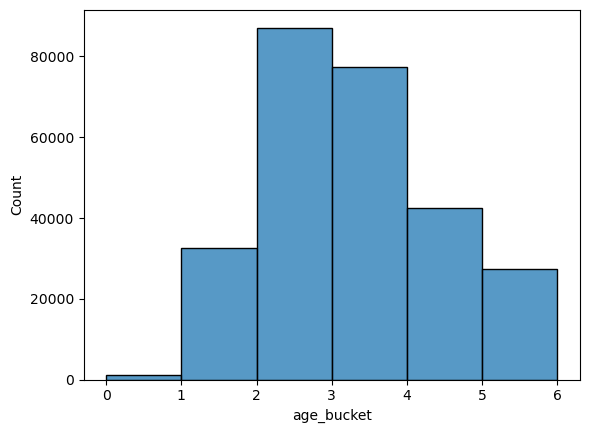

In [60]:
# распределение по возрастным бакетам
sns.histplot(data_age['age_bucket'], bins = 6)

In [61]:
y_age = data_age.age_bucket
y_age.head()

0    2
1    2
2    3
3    2
4    4
Name: age_bucket, dtype: int64

In [102]:
#pipe_age = make_pipeline(MaxAbsScaler(), SGDClassifier(random_state=10, n_jobs=-1, early_stopping=True)) #0.42097519900851116
#cls_age = BaggingClassifier(pipe_age, n_estimators=50, random_state=10, verbose=1, n_jobs=-1)
cls_age = CatBoostClassifier(iterations=300, verbose=10, random_state=10)  #0.4535361840975769

In [ ]:
# кросс-валидация
#cross_val = cross_validate(cls_age, X_age, y_age, cv=3, return_train_score=True)
#print('train score: ', cross_val['train_score'])
#print('test score: ', cross_val['test_score'])

In [103]:
cls_age.fit(X_age, y_age)

Learning rate set to 0.29106
0:	learn: 1.7237353	total: 27.3s	remaining: 2h 16m 9s
10:	learn: 1.3864922	total: 4m 4s	remaining: 1h 47m 12s
20:	learn: 1.3560245	total: 6m 54s	remaining: 1h 31m 51s
30:	learn: 1.3399598	total: 9m 44s	remaining: 1h 24m 35s
40:	learn: 1.3280364	total: 12m 35s	remaining: 1h 19m 30s
50:	learn: 1.3161591	total: 15m 31s	remaining: 1h 15m 47s
60:	learn: 1.3071851	total: 18m 18s	remaining: 1h 11m 45s
70:	learn: 1.3000844	total: 20m 59s	remaining: 1h 7m 41s
80:	learn: 1.2942321	total: 23m 40s	remaining: 1h 4m
90:	learn: 1.2893786	total: 26m 24s	remaining: 1h 39s
100:	learn: 1.2845241	total: 29m 2s	remaining: 57m 12s
110:	learn: 1.2801119	total: 32m 6s	remaining: 54m 40s
120:	learn: 1.2769052	total: 34m 31s	remaining: 51m 5s
130:	learn: 1.2735399	total: 36m 55s	remaining: 47m 38s
140:	learn: 1.2707081	total: 39m 14s	remaining: 44m 15s
150:	learn: 1.2682081	total: 41m 47s	remaining: 41m 13s
160:	learn: 1.2659274	total: 44m 8s	remaining: 38m 6s
170:	learn: 1.2630695	

In [104]:
print(m.classification_report(y_age, cls_age.predict(X_age), \
    target_names = ['<19', '19-25','26-35', '36-45', '46-55', '56-65', '65+']))

              precision    recall  f1-score   support

         <19       0.40      0.02      0.04      1047
       19-25       0.57      0.35      0.43     32603
       26-35       0.51      0.66      0.58     87156
       36-45       0.43      0.55      0.48     77386
       46-55       0.43      0.25      0.32     42376
       56-65       0.50      0.24      0.32     23545
         65+       0.61      0.02      0.03      3784

    accuracy                           0.48    267897
   macro avg       0.49      0.30      0.31    267897
weighted avg       0.48      0.48      0.46    267897



In [105]:
print('F1 score по возрасту: ', m.f1_score(y_age, cls_age.predict(X_age), average='weighted'))
#F1 score по возрасту:  0.4535361840975769

F1 score по возрасту:  0.45879941282405484


## Возраст: предсказание

In [106]:
# урлы-предикторы преобразуем в векторы, получим sparse matrix
X_urls_age_submit = tfidf_urls_age.transform(submit['url_host'])
X_urls_age

<267897x96328 sparse matrix of type '<class 'numpy.float64'>'
	with 27428958 stored elements in Compressed Sparse Row format>

In [107]:
X_cpe_age_submit = ohe_cpe_age.transform(np.array(submit.cpe).reshape(-1, 1))
X_cpe_age_submit

<144724x603 sparse matrix of type '<class 'numpy.float64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [108]:
# часть суток
X_part_of_day_cnt_age_submit = sparse.csr_matrix(np.array(submit[['day', 'evening', 'morning', 'night']]))
X_part_of_day_cnt_age_submit

<144724x4 sparse matrix of type '<class 'numpy.int64'>'
	with 531594 stored elements in Compressed Sparse Row format>

In [109]:
X_region_age_submit = ohe_region_age.transform(np.array(submit.region_name).reshape(-1, 1))
X_region_age_submit

<144724x290 sparse matrix of type '<class 'numpy.float64'>'
	with 144652 stored elements in Compressed Sparse Row format>

In [110]:
X_uniq_urls_cnt_age_submit = sparse.csr_matrix(np.array(submit['uniq_urls_cnt']).reshape(-1, 1))
X_uniq_urls_cnt_age_submit

<144724x1 sparse matrix of type '<class 'numpy.int64'>'
	with 144724 stored elements in Compressed Sparse Row format>

In [111]:
# матрица данных по дням недели
X_weekday_age_submit = sparse.csr_matrix(np.array(submit[['0', '1', '2', '3', '4', '5', '6']]))
X_weekday_age_submit

<144724x7 sparse matrix of type '<class 'numpy.int64'>'
	with 864751 stored elements in Compressed Sparse Row format>

In [112]:
# список регионов преобразуем в векторы
X_regions_join_age_submit= tfidf_regions_age.fit_transform(submit['region_name_join'])
X_regions_join_age_submit

<144724x89 sparse matrix of type '<class 'numpy.float64'>'
	with 282266 stored elements in Compressed Sparse Row format>

In [113]:
# соберем все вместе
X_age_submit = hstack((X_urls_age_submit, X_cpe_age_submit, X_part_of_day_cnt_age_submit, 
                       X_region_age_submit, X_uniq_urls_cnt_age_submit, X_weekday_age_submit, X_regions_join_age_submit))
X_age_submit

<144724x97322 sparse matrix of type '<class 'numpy.float64'>'
	with 16946868 stored elements in COOrdinate format>

In [114]:
predict_age = cls_age.predict(X_age_submit)
predict_age

array([[2],
       [3],
       [2],
       ...,
       [3],
       [3],
       [3]])

In [115]:
id_to_submit['age'] = predict_age.astype(int)
id_to_submit

,user_id,is_male,age
0,221301,0.982698,2
1,31271,0.541833,3
2,211594,0.538488,2
3,253119,0.482354,2
4,192578,0.848419,3
...,...,...,...
144719,415284,0.621984,2
144720,415285,0.563409,3
144721,415286,0.499156,3
144722,415306,0.673613,3


In [116]:
id_to_submit['age'].value_counts()

2    61426
3    53861
4    13061
1    10170
5     6120
6       56
0       30
Name: age, dtype: int64

In [117]:
id_to_submit.to_csv('submission.csv', index=False)

In [118]:
tmp  =  pd.read_csv('/kaggle/working/submission.csv')
tmp.head(20)

,user_id,is_male,age
0,221301,0.982698,2
1,31271,0.541833,3
2,211594,0.538488,2
3,253119,0.482354,2
4,192578,0.848419,3
5,268458,0.225789,2
6,205507,0.579084,2
7,341343,0.529516,3
8,282144,0.207774,2
9,373903,0.873845,1


# Score

In [119]:
sex_gini = 2 * m.roc_auc_score(y_sex, cls_sex.predict_proba(X_sex)[:,1]) - 1
print(sex_gini)
age_f1 = m.f1_score(y_age, cls_age.predict(X_age), average='weighted')
print(age_f1)
validation_score = 2 * age_f1 + sex_gini
print(validation_score)

NotFittedError: This BaggingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
0.8123153026193994
0.453060145311653
1.7184355932427056